# Chapter 17: Signal processing

Robert Johansson

Source code listings for [Numerical Python - A Practical Techniques Approach for Industry](http://www.apress.com/9781484205549) (ISBN 978-1-484205-54-9).

The source code listings can be downloaded from http://www.apress.com/9781484205549

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import matplotlib as mpl

In [5]:
from scipy import fftpack

In [6]:
# this also works:
# from numpy import fft as fftpack

In [7]:
from scipy import signal

In [8]:
import scipy.io.wavfile

In [9]:
from scipy import io

## Spectral analysis of simulated signal

In [10]:
def signal_samples(t):
    """ Simulated signal samples """
    return (2 * np.sin(1 * 2 * np.pi * t) +
            3 * np.sin(22 * 2 * np.pi * t) +
            2 * np.random.randn(*np.shape(t)))

In [11]:
np.random.seed(0)

In [12]:
B = 30.0

In [13]:
f_s = 2 * B
f_s

60.0

In [14]:
delta_f = 0.01

In [15]:
N = int(f_s / delta_f)
N

6000

In [16]:
T = N / f_s
T

100.0

In [17]:
f_s / N

0.01

In [18]:
t = np.linspace(0, T, N)

In [19]:
f_t = signal_samples(t)

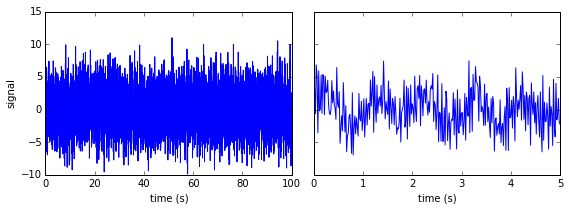

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")
fig.tight_layout()
fig.savefig("ch17-simulated-signal.pdf")
fig.savefig("ch17-simulated-signal.png")

In [21]:
F = fftpack.fft(f_t)

In [22]:
f = fftpack.fftfreq(N, 1/f_s)

In [23]:
mask = np.where(f >= 0)

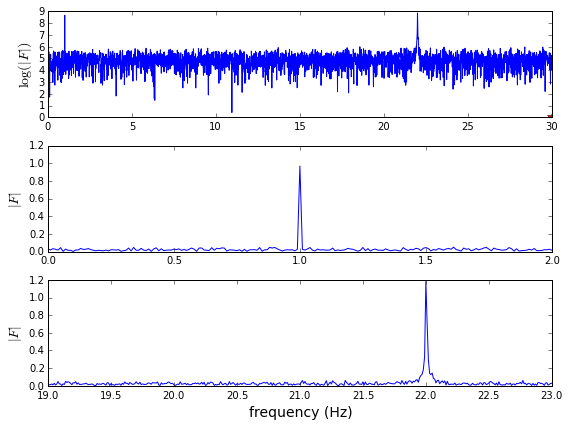

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(f[mask], abs(F[mask])/N, label="real")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|$", fontsize=14)

axes[2].plot(f[mask], abs(F[mask])/N, label="real")
axes[2].set_xlim(19, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$|F|$", fontsize=14)

fig.tight_layout()
fig.savefig("ch17-simulated-signal-spectrum.pdf")
fig.savefig("ch17-simulated-signal-spectrum.png")

## Simple example of filtering

In [25]:
F_filtered = F * (abs(f) < 2)

In [26]:
f_t_filtered = fftpack.ifft(F_filtered)

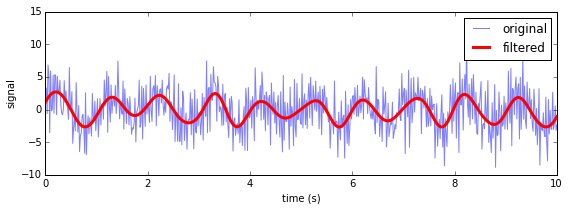

In [27]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label='original', alpha=0.5)
ax.plot(t, f_t_filtered.real, color="red", lw=3, label='filtered')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend()
fig.tight_layout()
fig.savefig("ch17-inverse-fft.pdf")
fig.savefig("ch17-inverse-fft.png")

## Windowing

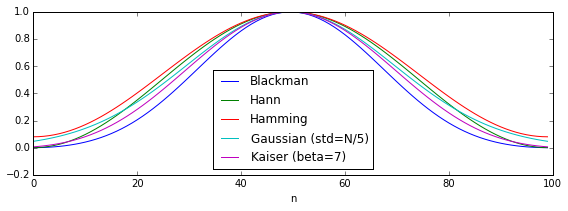

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N), label="Blackman")
ax.plot(signal.hann(N), label="Hann")
ax.plot(signal.hamming(N), label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5)")
ax.plot(signal.kaiser(N, 7), label="Kaiser (beta=7)")
ax.set_xlabel("n")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-window-functions.pdf")

In [29]:
df = pd.read_csv('temperature_outdoor_2014.tsv', delimiter="\t", names=["time", "temperature"])

In [30]:
df.time = pd.to_datetime(df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm')

In [31]:
df = df.set_index("time")

In [32]:
df = df.resample("1H")

In [33]:
df = df[(df.index < "2014-06-01")]

In [34]:
df = df.fillna(method='ffill')

In [35]:
time = df.index.astype('int')/1e9

In [36]:
temperature = df.temperature.values

In [37]:
temperature_detrended = signal.detrend(temperature)

In [38]:
window = signal.blackman(len(temperature_detrended))

In [39]:
data_fft_window = fftpack.fft(temperature_detrended * window)

In [40]:
data_fft = fftpack.fft(temperature_detrended)

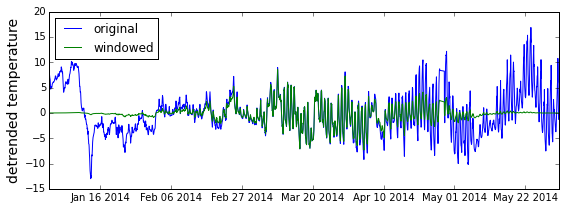

In [41]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature_detrended, label="original")
ax.plot(df.index, temperature_detrended * window, label="windowed")
ax.set_ylabel("detrended temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal.pdf")

In [42]:
f = fftpack.fftfreq(len(temperature_detrended), time[1]-time[0])

In [43]:
mask = f > 0

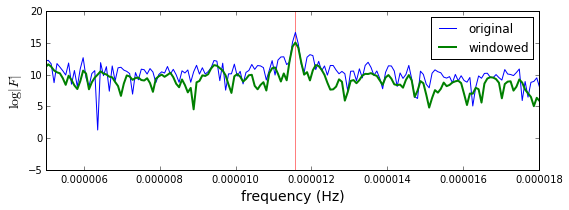

In [44]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0.000001, 0.000025)
ax.set_xlim(0.000005, 0.000018)
ax.axvline(1./86400, color='r', lw=0.5)
ax.plot(f[mask], np.log(abs(data_fft[mask])**2), lw=1, label="original")
ax.plot(f[mask], np.log(abs(data_fft_window[mask])**2), lw=2, label="windowed")
ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-spectrum.pdf")

## Spectrogram of Guitar sound

In [45]:
# https://www.freesound.org/people/guitarguy1985/sounds/52047/

In [46]:
sample_rate, data = io.wavfile.read("guitar.wav")

In [47]:
sample_rate

44100

In [48]:
data.shape

(1181625, 2)

In [49]:
data = data.mean(axis=1)

In [50]:
data.shape[0] / sample_rate

26

In [51]:
N = int(sample_rate/2.0); N # half a second

22050

In [52]:
f = fftpack.fftfreq(N, 1.0/sample_rate)

In [53]:
t = np.linspace(0, 0.5, N)

In [54]:
mask = (f > 0) * (f < 1000)

In [55]:
subdata = data[:N]

In [56]:
F = fftpack.fft(subdata)

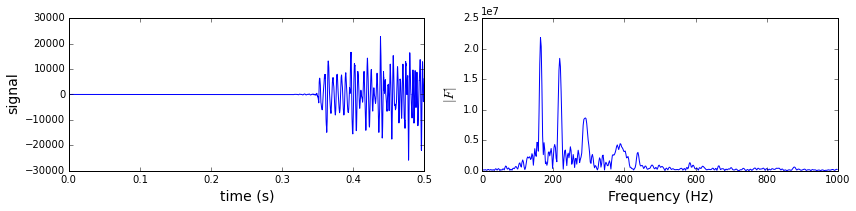

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-guitar-spectrum.pdf")

In [58]:
N_max = int(data.shape[0] / N)

In [59]:
f_values = np.sum(1 * mask)

In [60]:
spect_data = np.zeros((N_max, f_values))

In [61]:
window = signal.blackman(len(subdata))

In [62]:
for n in range(0, N_max):
    subdata = data[(N * n):(N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spect_data[n, :] = np.log(abs(F[mask]))

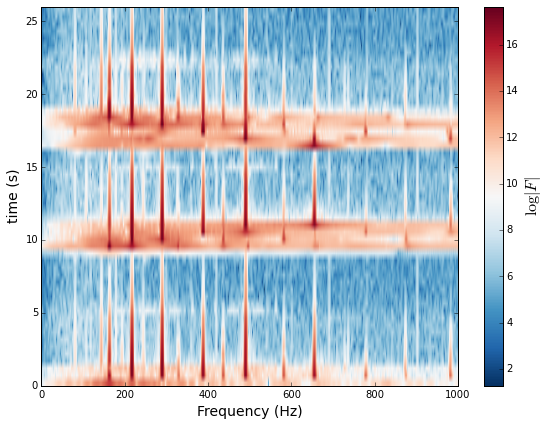

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(spect_data, origin='lower',
              extent=(0, 1000, 0, data.shape[0] / sample_rate),
              aspect='auto',
              cmap=mpl.cm.RdBu_r)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-spectrogram.pdf")
fig.savefig("ch17-spectrogram.png")

## Signal filters

### Convolution filters

In [64]:
# restore variables from the first example
np.random.seed(0)
B = 30.0
f_s = 2 * B
delta_f = 0.01
N = int(f_s / delta_f)
T = N / f_s
t = np.linspace(0, T, N)
f_t = signal_samples(t)
f = fftpack.fftfreq(N, 1/f_s)

In [65]:
H = (abs(f) < 2)

In [66]:
h = fftpack.fftshift(fftpack.ifft(H))

In [67]:
f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

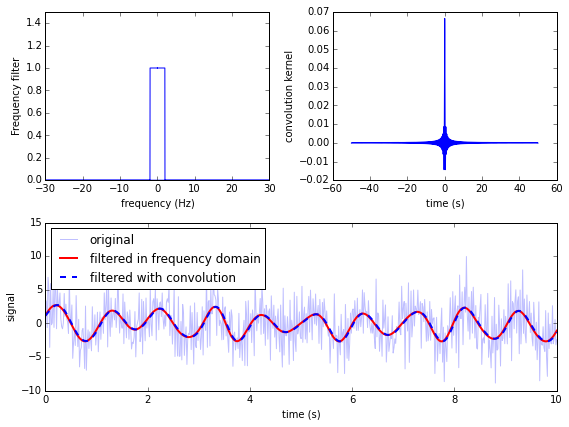

In [68]:
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - 50, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real, "r", lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

fig.tight_layout()
fig.savefig("ch17-convolution-filter.pdf")
fig.savefig("ch17-convolution-filter.png")

### FIR filter

In [69]:
n = 101

In [70]:
f_s = 1.0 / 3600

In [71]:
nyq = f_s/2

In [72]:
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

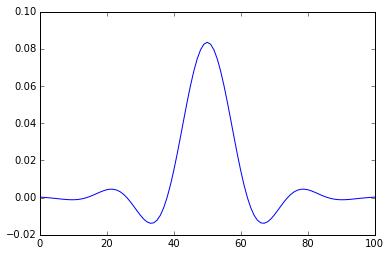

In [73]:
plt.plot(b);

In [74]:
f, h = signal.freqz(b)

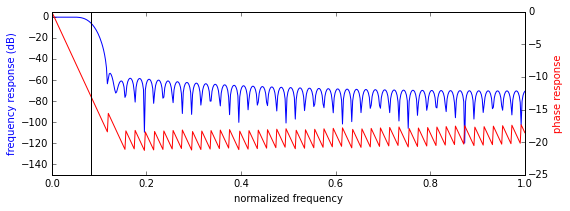

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase response', color="r")
ax.axvline(1.0/12, color="black")
fig.tight_layout()
fig.savefig("ch17-filter-frequency-response.pdf")

In [76]:
temperature_filtered = signal.lfilter(b, 1, temperature)

In [77]:
temperature_median_filtered = signal.medfilt(temperature, 25)

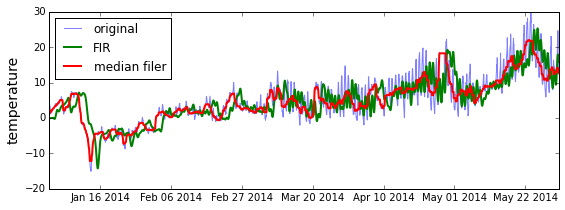

In [78]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered, color="green", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filtered, color="red", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-fir.pdf")

### IIR filter

In [79]:
b, a = signal.butter(2, 14/365.0, btype='high')

In [80]:
b

array([ 0.91831745, -1.8366349 ,  0.91831745])

In [81]:
a

array([ 1.        , -1.82995169,  0.8433181 ])

In [82]:
temperature_filtered_iir = signal.lfilter(b, a, temperature)

In [83]:
temperature_filtered_filtfilt = signal.filtfilt(b, a, temperature)

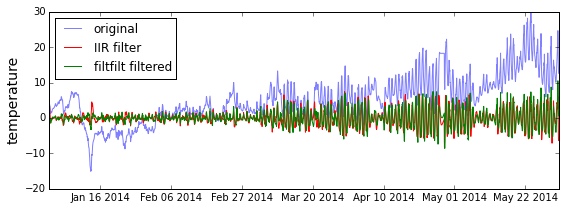

In [84]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered_iir, color="red", label="IIR filter")
ax.plot(df.index, temperature_filtered_filtfilt, color="green", label="filtfilt filtered")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-iir.pdf")

In [85]:
# f, h = signal.freqz(b, a)

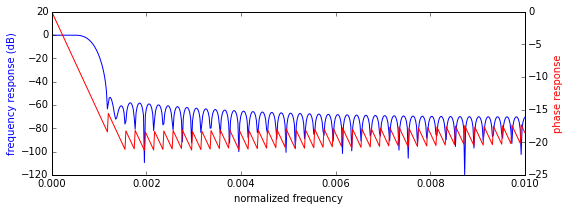

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f)/100, h_ampl, 'b')
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f)/100, h_phase, 'r')
ax.set_ylabel('phase response', color="r")
fig.tight_layout()

### Filtering Audio

In [87]:
b = np.zeros(5000)
b[0] = b[-1] = 1
b /= b.sum()

In [88]:
data_filt = signal.lfilter(b, 1, data)

In [89]:
io.wavfile.write("guitar-echo.wav",
                 sample_rate,
                 np.vstack([data_filt, data_filt]).T.astype(np.int16))

In [90]:
# based on: http://nbviewer.ipython.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
from IPython.core.display import display
from IPython.core.display import HTML
def wav_player(filepath):
    src = """
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
    </audio>
    """%(filepath)
    display(HTML(src))

In [91]:
wav_player("guitar.wav")

In [92]:
wav_player("guitar-echo.wav")

# Versions

In [94]:
%reload_ext version_information

In [95]:
%version_information numpy, matplotlib, scipy

Software,Version
Python,2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython,3.2.1
OS,Darwin 14.1.0 x86_64 i386 64bit
numpy,1.9.2
matplotlib,1.4.3
scipy,0.16.0
